In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import gym
import matplotlib.pyplot as plt

from collections import defaultdict
from itertools import product as itprod
from tqdm import tqdm

%matplotlib inline

# Часть первая, с блекджеком и стратегиями

Мы будем обучаться играть в очень простую, но всё-таки знаменитую и популярную игру: блекджек. Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
- численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
- туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
- игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
- игрок может совершать одно из двух действий:
hit  — взять ещё одну карту;
stand — не брать больше карт;
- если сумма очков у игрока на руках больше 21, он проигрывает (bust);
- если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
- после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
- в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).

Именно этот простейший вариант блекджека реализован в OpenAI Gym:
https://github.com/openai/gym/blob/38a1f630dc9815a567aaf299ae5844c8f8b9a6fa/gym/envs/toy_text/blackjack.py

#### Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [2]:
np.random.seed(1)

In [59]:
def play_episode_naive(env):
    s = env.reset()
    done = False
    while not done:
        action = 1 if s[0] < 19 else 0 
        next_state, reward, done, _ = env.step(action)
        s = next_state
    return reward

def evaluate_pi(Q):
    return Q.argmax(1)

def play_by_pi(Q, env, n_episodes=500_000):
    rewards = []
    pi = evaluate_pi(Q)
    for _ in range(n_episodes):
        s = states_map[env.reset()]
        done = False
        while not done:
            a = pi[s]
            s, r, done, _ = env.step(a)
            s = states_map[s]
        rewards.append(r)
    return rewards

def q_learning(Q, env, states_map, alpha=0.01, gamma=1, epsilon=0.01):
    s = states_map[env.reset()]
    done = False
    while not done: 
        pi = evaluate_pi(Q)
        a = pi[s] if np.random.rand() > epsilon else env.action_space.sample()
        next_state, r, done, _ = env.step(a)
        next_state = states_map[next_state]
        Q[s][a] = Q[s][a] + alpha * (r + gamma * np.max(Q[next_state]) - Q[s][a])
        s = next_state
    return Q

def train(states_map, env, alpha=0.0001, gamma=1, epsilon=0.9, n_episodes=500_000):
    Q = np.zeros((len(states), env.action_space.n))
    for _ in range(n_episodes):
        Q = q_learning(Q, env, states_map, alpha, gamma, epsilon)
    return Q

def grid_param(param_name, param_space, params, states_map, env, n_episodes_train=500_000, n_episodes_eval=500_000):
    best_r = -np.inf
    best_param = None
    for param_value in param_space:
        params[param_name] = param_value
        Q = train(states_map, env, **params, n_episodes=n_episodes_train)
        r = np.mean(play_by_pi(Q, env, n_episodes=n_episodes_eval))
        if r > best_r:
            best_r = r
            best_param = param_value
        print(f'{params} \t reward: {r}')
    return best_param
        
def evaluate_reward(states_map, env, alpha, epsilon, gamma, n_episodes_train=500_000, n_episodes_eval=500_000,
                    eval_every=20_000):
    Q = np.zeros((len(states), env.action_space.n))
    rewards = []
    for i in range(n_episodes_train):
        Q = q_learning(Q, env, states_map, alpha=alpha, gamma=gamma, epsilon=epsilon)
        if i == 0 or (i + 1) % eval_every == 0:
            r = np.mean(play_by_pi(Q, env, n_episodes=n_episodes_eval))
            rewards.append(r)
            print(f'Итерация {i + 1}: {r}')
    return rewards, Q

In [4]:
env = gym.make('Blackjack-v0', natural=True)

In [5]:
rewards = np.array([play_episode_naive(env) for _ in range(500_000)])

In [6]:
print(f'Средняя прибыль от наивной стратегии: {np.mean(rewards)}')

Средняя прибыль от наивной стратегии: -0.179443


По наивной стратегии мы много проигрываем, попробуем реализовать Q-learning. Поперебираем основные параметры.

In [7]:
space = env.observation_space
states = list(itprod(range(1, space[0].n + 1), range(1, space[1].n + 1), [False, True]))
states_map = dict(zip(states, range(len(states))))
Q = np.zeros((len(states), env.action_space.n))

In [8]:
alpha = 0.0001
gamma = 1
epsilon = 0.9

In [13]:
params = {
    'alpha': alpha,
    'gamma': gamma,
    'epsilon': epsilon
}
alpha_space = [0.0001, 0.0002, 0.0003, 0.0005, 0.001, 0.002, 0.005]
alpha = grid_param('alpha', alpha_space, params, states_map, env)

{'alpha': 0.0001, 'gamma': 1, 'epsilon': 0.9} 	 reward: -0.032876
{'alpha': 0.0002, 'gamma': 1, 'epsilon': 0.9} 	 reward: -0.031823
{'alpha': 0.0003, 'gamma': 1, 'epsilon': 0.9} 	 reward: -0.053438
{'alpha': 0.0005, 'gamma': 1, 'epsilon': 0.9} 	 reward: -0.057681
{'alpha': 0.001, 'gamma': 1, 'epsilon': 0.9} 	 reward: -0.119568
{'alpha': 0.002, 'gamma': 1, 'epsilon': 0.9} 	 reward: -0.14657
{'alpha': 0.005, 'gamma': 1, 'epsilon': 0.9} 	 reward: -0.126862


In [17]:
params = {
    'alpha': alpha,
    'gamma': gamma,
    'epsilon': epsilon
}
epsilon_space = [0.01, 0.25, 0.5, 0.75, 0.9, 0.92, 0.95, 0.98, 0.99]
epsilon = grid_param('epsilon', epsilon_space, params, states_map, env)

{'alpha': 0.0002, 'gamma': 1, 'epsilon': 0.01} 	 reward: -0.083467
{'alpha': 0.0002, 'gamma': 1, 'epsilon': 0.25} 	 reward: -0.052781
{'alpha': 0.0002, 'gamma': 1, 'epsilon': 0.5} 	 reward: -0.057574
{'alpha': 0.0002, 'gamma': 1, 'epsilon': 0.75} 	 reward: -0.058407
{'alpha': 0.0002, 'gamma': 1, 'epsilon': 0.9} 	 reward: -0.033677
{'alpha': 0.0002, 'gamma': 1, 'epsilon': 0.92} 	 reward: -0.03359
{'alpha': 0.0002, 'gamma': 1, 'epsilon': 0.95} 	 reward: -0.031934
{'alpha': 0.0002, 'gamma': 1, 'epsilon': 0.98} 	 reward: -0.031805
{'alpha': 0.0002, 'gamma': 1, 'epsilon': 0.99} 	 reward: -0.031517


In [22]:
params = {
    'alpha': alpha,
    'gamma': gamma,
    'epsilon': epsilon
}
gamma_space = np.linspace(0, 1, 11)
gamma = grid_param('gamma', gamma_space, params, states_map, env)

{'alpha': 0.0002, 'gamma': 0.0, 'epsilon': 0.99} 	 reward: -0.031878
{'alpha': 0.0002, 'gamma': 0.1, 'epsilon': 0.99} 	 reward: -0.032188
{'alpha': 0.0002, 'gamma': 0.2, 'epsilon': 0.99} 	 reward: -0.034291
{'alpha': 0.0002, 'gamma': 0.30000000000000004, 'epsilon': 0.99} 	 reward: -0.03035
{'alpha': 0.0002, 'gamma': 0.4, 'epsilon': 0.99} 	 reward: -0.029369
{'alpha': 0.0002, 'gamma': 0.5, 'epsilon': 0.99} 	 reward: -0.029263
{'alpha': 0.0002, 'gamma': 0.6000000000000001, 'epsilon': 0.99} 	 reward: -0.034986
{'alpha': 0.0002, 'gamma': 0.7000000000000001, 'epsilon': 0.99} 	 reward: -0.035298
{'alpha': 0.0002, 'gamma': 0.8, 'epsilon': 0.99} 	 reward: -0.034983
{'alpha': 0.0002, 'gamma': 0.9, 'epsilon': 0.99} 	 reward: -0.032704
{'alpha': 0.0002, 'gamma': 1.0, 'epsilon': 0.99} 	 reward: -0.032846


In [25]:
rewards_history, Q = evaluate_reward(states_map, env, alpha=alpha, epsilon=epsilon, gamma=gamma)

Итерация 0: -0.167384
Итерация 20000: -0.039245
Итерация 40000: -0.033144
Итерация 60000: -0.030057
Итерация 80000: -0.032259
Итерация 100000: -0.032211
Итерация 120000: -0.033045
Итерация 140000: -0.031419
Итерация 160000: -0.031154
Итерация 180000: -0.030853
Итерация 200000: -0.031578
Итерация 220000: -0.031132
Итерация 240000: -0.027889
Итерация 260000: -0.027285
Итерация 280000: -0.030024
Итерация 300000: -0.028162
Итерация 320000: -0.02789
Итерация 340000: -0.029119
Итерация 360000: -0.028773
Итерация 380000: -0.025468
Итерация 400000: -0.028786
Итерация 420000: -0.030489
Итерация 440000: -0.029665
Итерация 460000: -0.028351
Итерация 480000: -0.028356


In [26]:
rewards = play_by_pi(Q, env, n_episodes=500_000)

print(f'Средняя прибыль от RL: {np.mean(rewards)}')

Средняя прибыль от RL: -0.026414


Уже лучше, такая стратегия значительно выгоднее, хотя мы все еще проигрываем.

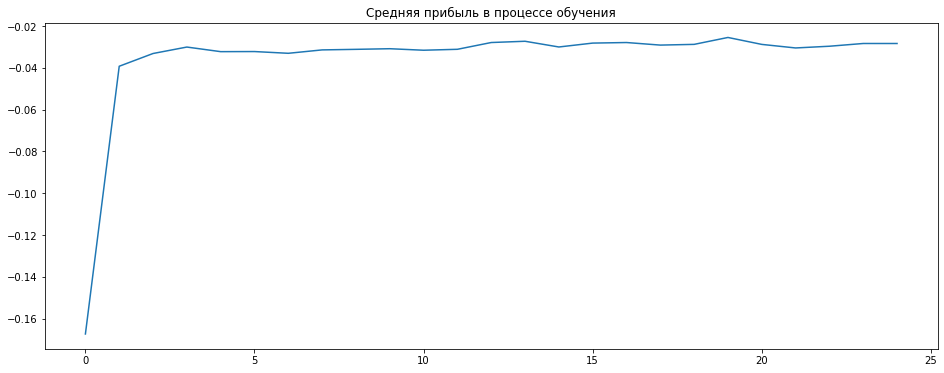

In [27]:
plt.figure(figsize=(16, 6))
plt.title('Средняя прибыль в процессе обучения')
plt.plot(rewards_history);

# Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
- double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.
- Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.
- Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [28]:
from BlackjackEnvWithDouble import BlackjackEnvWithDouble

In [29]:
env = BlackjackEnvWithDouble(natural=True)

In [ ]:
params = {
    'alpha': alpha,
    'gamma': gamma,
    'epsilon': epsilon
}
epsilon_space = np.linspace(0.9, 0.99, 10)
epsilon = grid_param('epsilon', epsilon_space, params, states_map, env)

{'alpha': 0.0002, 'gamma': 0.5, 'epsilon': 0.9} 	 reward: -0.022305
{'alpha': 0.0002, 'gamma': 0.5, 'epsilon': 0.91} 	 reward: -0.017359
{'alpha': 0.0002, 'gamma': 0.5, 'epsilon': 0.92} 	 reward: -0.021397
{'alpha': 0.0002, 'gamma': 0.5, 'epsilon': 0.93} 	 reward: -0.016208
{'alpha': 0.0002, 'gamma': 0.5, 'epsilon': 0.9400000000000001} 	 reward: -0.014558
{'alpha': 0.0002, 'gamma': 0.5, 'epsilon': 0.95} 	 reward: -0.019484
{'alpha': 0.0002, 'gamma': 0.5, 'epsilon': 0.96} 	 reward: -0.017002
{'alpha': 0.0002, 'gamma': 0.5, 'epsilon': 0.97} 	 reward: -0.019636
{'alpha': 0.0002, 'gamma': 0.5, 'epsilon': 0.98} 	 reward: -0.019292


In [31]:
params = {
    'alpha': alpha,
    'gamma': gamma,
    'epsilon': epsilon
}
gamma_space = np.linspace(0.2, 0.5, 11)
gamma = grid_param('gamma', gamma_space, params, states_map, env)

{'alpha': 0.0002, 'gamma': 0.23, 'epsilon': 0.9400000000000001} 	 reward: -0.018881
{'alpha': 0.0002, 'gamma': 0.26, 'epsilon': 0.9400000000000001} 	 reward: -0.017971
{'alpha': 0.0002, 'gamma': 0.29000000000000004, 'epsilon': 0.9400000000000001} 	 reward: -0.023475
{'alpha': 0.0002, 'gamma': 0.32, 'epsilon': 0.9400000000000001} 	 reward: -0.02189
{'alpha': 0.0002, 'gamma': 0.35, 'epsilon': 0.9400000000000001} 	 reward: -0.016902
{'alpha': 0.0002, 'gamma': 0.38, 'epsilon': 0.9400000000000001} 	 reward: -0.017763
{'alpha': 0.0002, 'gamma': 0.41000000000000003, 'epsilon': 0.9400000000000001} 	 reward: -0.020995
{'alpha': 0.0002, 'gamma': 0.44, 'epsilon': 0.9400000000000001} 	 reward: -0.024072
{'alpha': 0.0002, 'gamma': 0.47000000000000003, 'epsilon': 0.9400000000000001} 	 reward: -0.022213
{'alpha': 0.0002, 'gamma': 0.5, 'epsilon': 0.9400000000000001} 	 reward: -0.023861


In [32]:
rewards_history, Q = evaluate_reward(states_map, env, alpha=alpha, epsilon=epsilon, gamma=gamma)

Итерация 0: -0.166958
Итерация 20000: -0.044151
Итерация 40000: -0.036743
Итерация 60000: -0.034173
Итерация 80000: -0.028665
Итерация 100000: -0.024074
Итерация 120000: -0.026012
Итерация 140000: -0.018923
Итерация 160000: -0.020679
Итерация 180000: -0.020268
Итерация 200000: -0.021457
Итерация 220000: -0.019783
Итерация 240000: -0.02023
Итерация 260000: -0.021628
Итерация 280000: -0.019504
Итерация 300000: -0.020286
Итерация 320000: -0.018816
Итерация 340000: -0.018397
Итерация 360000: -0.016684
Итерация 380000: -0.019041
Итерация 400000: -0.022779
Итерация 420000: -0.020295
Итерация 440000: -0.021307
Итерация 460000: -0.020374
Итерация 480000: -0.017331


In [33]:
rewards = play_by_pi(Q, env, n_episodes=500_000)

print(f'Средняя прибыль от RL: {np.mean(rewards)}')

Средняя прибыль от RL: -0.017995


Видим, что с возможностью удвоения наши потери существенно снизились.

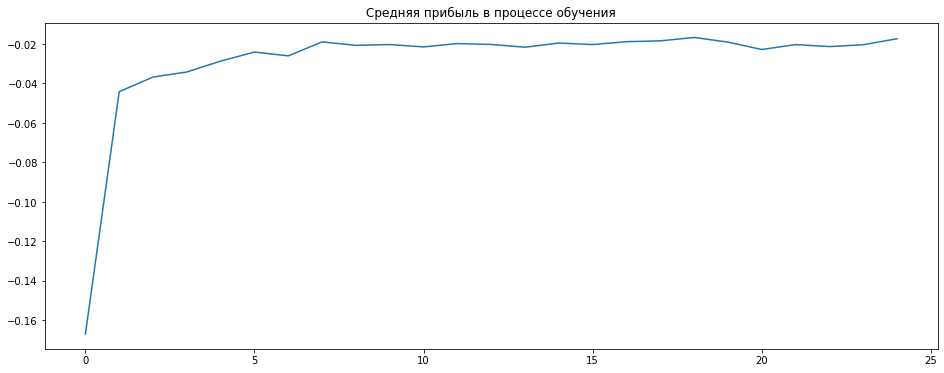

In [34]:
plt.figure(figsize=(16, 6))
plt.title('Средняя прибыль в процессе обучения')
plt.plot(rewards_history);

# Часть третья, в главной роли — Дастин Хоффман

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.
- Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).
- Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

Используем стратегию подсчета карт из https://www.onlineblackjackrealmoney.org/card-counting/zen-count. Так как состояний стало значительно больше, увеличим количество итераций обучения.

In [60]:
from BlackjackEnvWithDoubleAndCount import BlackjackEnvWithDoubleAndCount

In [61]:
env = BlackjackEnvWithDoubleAndCount(natural=True)

In [62]:
space = env.observation_space
states = list(itprod(range(1, space[0].n + 1),
                     range(1, space[1].n + 1), 
                     [False, True], 
                     range(-space[3].n // 2, space[3].n // 2 + 1)))
states_map = dict(zip(states, range(len(states))))
Q = np.zeros((len(states), env.action_space.n))

In [52]:
rewards_history, Q = evaluate_reward(
    states_map, env, alpha=alpha, epsilon=epsilon, gamma=gamma, 
    n_episodes_train=20_000_000, n_episodes_eval=500_000, eval_every=500_000
)

Итерация 500000: -0.033342
Итерация 1000000: -0.022
Итерация 1500000: -0.02064
Итерация 2000000: -0.019226
Итерация 2500000: -0.017246
Итерация 3000000: -0.01671
Итерация 3500000: -0.011863
Итерация 4000000: -0.015561
Итерация 4500000: -0.017209
Итерация 5000000: -0.012977
Итерация 5500000: -0.011467
Итерация 6000000: -0.00952
Итерация 6500000: -0.011531
Итерация 7000000: -0.011192
Итерация 7500000: -0.01366
Итерация 8000000: -0.011484
Итерация 8500000: -0.00906
Итерация 9000000: -0.013127
Итерация 9500000: -0.008005
Итерация 10000000: -0.013211
Итерация 10500000: -0.010194
Итерация 11000000: -0.012401
Итерация 11500000: -0.009609
Итерация 12000000: -0.012723
Итерация 12500000: -0.009325
Итерация 13000000: -0.009299
Итерация 13500000: -0.011866
Итерация 14000000: -0.008791
Итерация 14500000: -0.008056
Итерация 15000000: -0.01003
Итерация 15500000: -0.010088
Итерация 16000000: -0.009788
Итерация 16500000: -0.006439
Итерация 17000000: -0.010843
Итерация 17500000: -0.007396
Итерация 18000

In [54]:
rewards = play_by_pi(Q, env, n_episodes=500_000)

print(f'Средняя прибыль от RL с удвоением ставки и подсчетом карт: {np.mean(rewards)}')

Средняя прибыль от RL с удвоением ставки и подсчетом карт: -0.004428


Теперь уже очень близко к тому, чтобы не проиграть, но все же нет=)

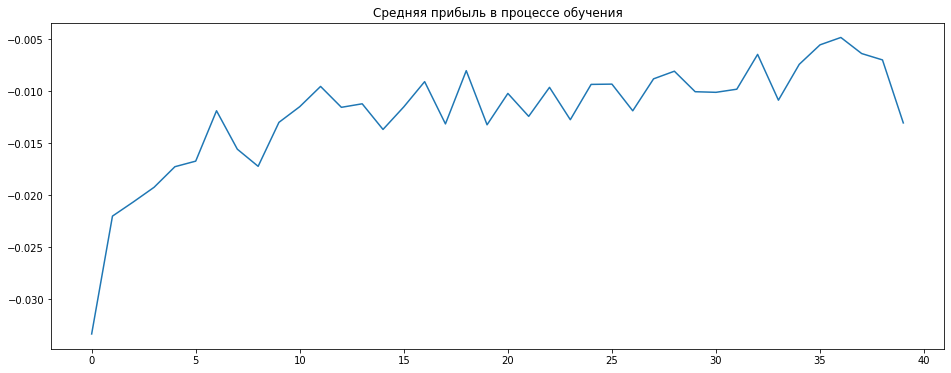

In [57]:
plt.figure(figsize=(16, 6))
plt.title('Средняя прибыль в процессе обучения')
plt.plot(rewards_history);

Таким образом, нам удалось создать агента, который практически смог играть в 0 с казино. Думаю, что с возможностью сплита у него бы этого получилось.